In [435]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.image as mpimg

In [436]:
# problem 1
def cross_correlation(input, filter, output, pad_r, pad_c):
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            output[i, j] = np.sum(input[i:i + 2*pad_r + 1, j:j + 2*pad_c + 1]*filter) 
    return output

def my_imfilter(input, filter, mode='reflect', convolution=True):
    """
    Parameters
    ------------
    input: the input image
    mode: {'reflect, 'constant'}, optional
          The mode parameter determines how the input array is padded. Default is 'reflect'.
    convolution: {True, Flase}, optional
          The convolution determines the operation is convolution or correlation. Default is Ture. 
    """
    # check filter size
    r,c = filter.shape[0], filter.shape[1]
    if r % 2 == 0 or c % 2 == 0:
        raise RuntimeError("Filter must be odd size.")
    input = np.array(input)
    filter = np.array(filter)
    # check ndim
    if(input.ndim != filter.ndim):
        raise RuntimeError("Filter and input has different dimension.")

    if convolution:
        # filp filter for convolution
        if filter.ndim > 2:
            for i in range(filter.shape[-1]):     
                filter[:,:,i] = np.flip(np.flip(filter[:,:,i],1), 0) 
        else:
            filter = np.flip(np.flip(filter,1), 0) 

    output = np.zeros(input.shape)

    # padding
    pad_r = (r - 1)//2  #rows to padding at top and bottom
    pad_c = (c - 1)//2  #columns to padding at left and right
    padding = ((pad_r, pad_r), (pad_c, pad_c))

    if input.ndim > 2:
        for i in range(input.shape[-1]): 
            padded_img = np.pad(input[:,:,i] ,padding, mode)
            output[:,:,i] = cross_correlation(padded_img, filter[:,:,i], output[:,:,i],pad_r, pad_c)
    else:
        padded_img = np.pad(input,padding, mode)
        output = cross_correlation(padded_img, filter, output,pad_r, pad_c)

    return output

Text(0.5, 1.0, 'Filtered Image')

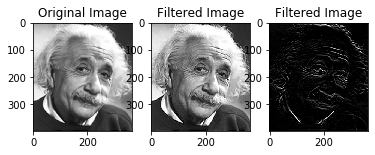

In [437]:
# test  gray scale image for problem 1
img = cv2.imread('./Image1.png',0) # read the image
filter = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]]) # sharpen filter
filter1 = np.array([[0, -1, 0],[-1, 6, -1],[0, -1, 0], [0, -1, 0], [0, -1, 0]]) # filter with arbitrary shape
new_img = my_imfilter(img, filter)
new_img1 = my_imfilter(img, filter1)
max_val = np.max(img)
min_val = np.min(img)
# bound the value to min_val - max_val
new_img[new_img < min_val] = min_val
new_img[new_img > max_val] = max_val

new_img1[new_img1 < min_val] = min_val
new_img1[new_img1 > max_val] = max_val

plt.subplot(131),plt.imshow(img,cmap = 'gray')
plt.title('Original Image')
plt.subplot(132),plt.imshow(new_img,cmap = 'gray')
plt.title('Filtered Image')
plt.subplot(133),plt.imshow(new_img1,cmap = 'gray')
plt.title('Filtered Image')




Text(0.5, 1.0, 'Filtered Image')

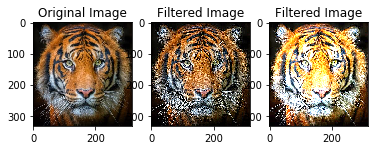

In [438]:
# test color image for problem 1
img = mpimg.imread('./Image4.png') # read the image
ndim = img.shape[-1]
filter = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]]) # sharpen filter from hw1
filter = np.expand_dims(filter,2) #expand to 3 dimension
filter = np.repeat(filter,ndim,-1) 
filter1 = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0], [0, 1, 0], [0, 0, 0]]) # filter with arbitrary shape
filter1 = np.expand_dims(filter1,2)
filter1 = np.repeat(filter1,ndim,-1)

new_img = my_imfilter(img, filter)
new_img1 = my_imfilter(img, filter1)
max_val = np.max(img)
min_val = np.min(img)
# bound the value to min_val - max_val
new_img[new_img < min_val] = min_val
new_img[new_img > max_val] = max_val

new_img1[new_img1 < min_val] = min_val
new_img1[new_img1 > max_val] = max_val

plt.subplot(131),plt.imshow(img)
plt.title('Original Image')
plt.subplot(132),plt.imshow(new_img)
plt.title('Filtered Image')
plt.subplot(133),plt.imshow(new_img1)
plt.title('Filtered Image')


In [439]:
# problem 2
# from scipy.ndimage import gaussian_filter

def gaussian_kernel(sigma):
    size = sigma*4 + 1
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

def hybridimg(img1, img2, cutoff):
    r1, c1 = img1.shape[0],img1.shape[1]
    r2, c2 = img2.shape[0],img2.shape[1]
    r = min(r1,r2)
    c = min(c1,c2)
    img1 = cv2.resize(img1,(r,c))
    img2 = cv2.resize(img2,(r,c))
    max_val = np.max(img1)
    min_val = np.min(img1)

    filter = gaussian_kernel(cutoff)
    if img1.ndim > 2:
        filter = np.expand_dims(filter,2) #expand to 3 dimension
        filter = np.repeat(filter,img1.ndim,-1) 

    # low pass
    # low_freq = gaussian_filter(img1, sigma=cutoff)
    low_freq = my_imfilter(img1,filter) /255
       
    # high pass
    # low_freq2 = gaussian_filter(img2, sigma=cutoff) 
    low_freq2 = my_imfilter(img2,filter)/255
    low_freq2[low_freq2 < min_val] = min_val
    low_freq2[low_freq2 > max_val] = max_val
    high_freq = img2.astype(int)/255 - low_freq2

    hybrid  = low_freq + high_freq
    return  hybrid 





In [440]:
img1 = cv2.imread('./Image1.png',0)
img2 = cv2.imread('./Image2.png',0)
img3 = cv2.imread('./Image3.png') 
img4 = cv2.imread('./Image4.png')


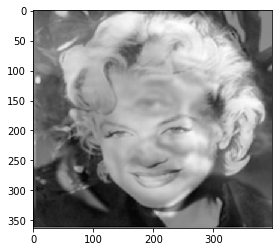

In [441]:
cutoff1 = 2
hybrid1 = hybridimg(img1, img2, cutoff) 
plt.imshow(hybrid1, cmap = 'gray')

Text(28.886622171179006, 0, '29')

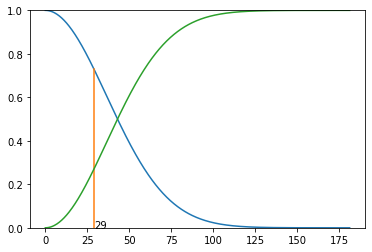

In [454]:
# Plot the frequency cut off, cut_off_freq = r/(2*np.pi*cutoff1) = 29
low_pass = gaussian_kernel(cutoff1)
c1 = img1.shape[1]
c2= img2.shape[1]
c = min(c1,c2)
x = np.arange(0,0.5,0.001)
a = 1/(cutoff1*np.sqrt(2*np.pi))
gx = np.exp(-np.pi**2*x**2/a)  #frequency response 
x =x*c
plt.ylim(ymin=0)  # this line
plt.plot(x, gx)
cut_off_freq = c/(2*np.pi*cutoff1) # tranfer to frequency domain
f = cut_off_freq/c
g = np.exp(-np.pi**2*f**2/a) 
point1 = [cut_off_freq,cut_off_freq]
point2 = [0,g]
plt.plot(point1,point2)

high_pass = np.zeros(low_pass.shape)
high_pass[low_pass.shape[0]//2][low_pass.shape[0]//2] = 1
gx = 1 - gx  # high frequency response 
plt.plot(x, gx)
plt.text(cut_off_freq,0,int(np.ceil(cut_off_freq)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


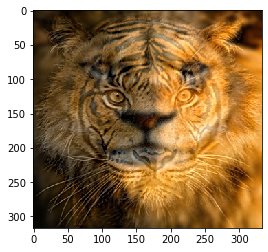

In [443]:
cutoff2 = 3
hybrid2 = hybridimg(img3, img4, cutoff) 
hybrid2 = hybrid2[:, :, ::-1]
plt.imshow(hybrid2)

Text(16.817372320043606, 0, '17')

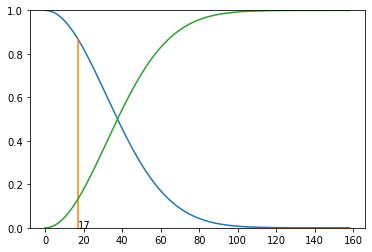

In [453]:
# Plot the frequency cut off, cut_off_freq = r/(2*np.pi*cutoff2) = 17
low_pass = gaussian_kernel(cutoff2)
c1 = img3.shape[1]
c2= img4.shape[1]
c = min(c1,c2)
x = np.arange(0,0.5,0.001)
a = 1/(cutoff1*np.sqrt(2*np.pi))
gx = np.exp(-np.pi**2*x**2/a)  #frequency response 
x =x*c
plt.ylim(ymin=0)  # this line
plt.plot(x, gx)
cut_off_freq = c/(2*np.pi*cutoff2) # tranfer to frequency domain
f = cut_off_freq/c
g = np.exp(-np.pi**2*f**2/a) 
point1 = [cut_off_freq,cut_off_freq]
point2 = [0,g]
plt.plot(point1,point2)
gx = 1 - gx  # high frequency response 
plt.plot(x, gx)
plt.text(cut_off_freq,0,int(np.ceil(cut_off_freq)))
